<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/s18_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo


Cloning into 'ERA_V1'...
remote: Enumerating objects: 1545, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 1545 (delta 64), reused 32 (delta 5), pack-reused 1407
Receiving objects: 100% (1545/1545), 202.23 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (756/756), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import sys
sys.path.append("ERA_V1/session_18")


Add all the imports:

In [19]:
from __future__ import print_function
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from unet_model import UNet
from data_loader import load_oxford_pet_data


Allocate GPU and print model summary

In [4]:
import torch
import torch.nn as nn


class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip = x  # store the output for the skip connection
        x = self.maxpool(x)
        return x, skip


class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.upsample(x)

        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.contract1 = ContractingBlock(in_channels, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)
        self.bottle_neck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.expand1 = ExpandingBlock(1024, 512)
        self.expand2 = ExpandingBlock(512, 256)
        self.expand3 = ExpandingBlock(256, 128)

        self.final_dim_reduction = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True)])

        self.final_block = nn.Conv2d(64, out_channels, kernel_size=1)



    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        x, skip2 = self.contract2(x)
        x, skip3 = self.contract3(x)
        x, skip4 = self.contract4(x)
        x = self.bottle_neck(x)
        x = self.upsample(x)
        x = torch.cat((x, skip4), dim=1)

        # Expanding path
        x3 = self.expand1(x, skip3)
        x2 = self.expand2(x3, skip2)
        x1 = self.expand3(x2, skip1)

        x  = self.final_dim_reduction(x1)
        x_out = self.final_block(x)
        return x_out



In [5]:
def model_summary(model, input_size):
    summary(model, input_size = input_size)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
unet_model = UNet(in_channels=3,out_channels=3).to(device)
model_summary(unet_model, input_size=(3,48,48))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
         MaxPool2d-7           [-1, 64, 24, 24]               0
  ContractingBlock-8  [[-1, 64, 24, 24], [-1, 64, 48, 48]]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
           Conv2d-12          [-1, 128, 24, 24]         147,584
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14        

In [7]:
import numpy as np
from typing import Any
from torchvision import datasets, transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

def oxford_transforms(image, mask):
    # Resize
    resize = transforms.Resize(size=(48, 48))
    image = resize(image)
    mask = resize(mask)

    # Transform to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    mask = np.asarray(mask)-1
    mask_channels = np.zeros((3, mask.shape[0], mask.shape[1]))
    for channel_id in range(3):
        mask_channels[channel_id,:,:] = mask == channel_id
    return image, torch.tensor(mask_channels, dtype=float)

class OxfordPetDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)


def load_oxford_pet_data(train_transforms, test_transforms, batch_size, **kwargs):
    train_data = datasets.OxfordIIITPet('../data', split='trainval', transforms = train_transforms, target_transform = None, target_types='segmentation', download=True)
    test_data = datasets.OxfordIIITPet('../data', split='test', transforms = test_transforms, target_transform = None, target_types='segmentation', download=True)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)
    return train_loader, test_loader




**Define train and test loaders**

In [8]:
torch.manual_seed(1)
batch_size = 32
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader = load_oxford_pet_data(train_transforms=oxford_transforms, test_transforms=oxford_transforms, batch_size=batch_size, **kwargs)

100%|██████████| 791918971/791918971 [00:50<00:00, 15676458.72it/s]


Extracting ../data/oxford-iiit-pet/images.tar.gz to ../data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8643622.92it/s] 


Extracting ../data/oxford-iiit-pet/annotations.tar.gz to ../data/oxford-iiit-pet


In [ ]:
a,b = next(iter(train_loader))
print(a.shape)
print(b.shape)

torch.Size([32, 3, 48, 48])
torch.Size([32, 3, 48, 48])


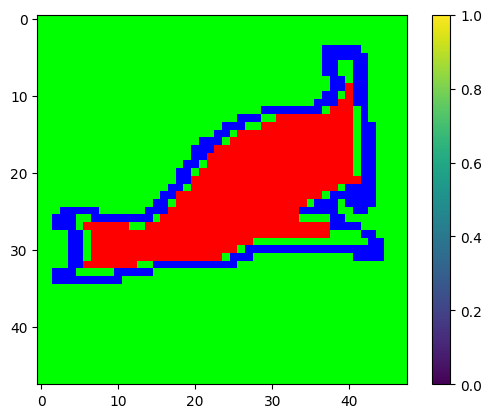

(48, 48, 3)


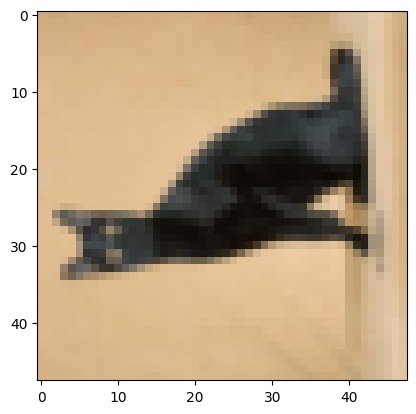

In [ ]:
idx=9
c = np.asarray(b[idx]).transpose()
a1 = np.asarray(a[idx]).squeeze().transpose()
import matplotlib.pyplot as plt
plt.imshow(c.squeeze())
plt.colorbar()
plt.show()
plt.figure()

print(a1.shape)
plt.imshow(a1)
plt.show()

**Define Training Step**

In [9]:
from tqdm import tqdm

def model_train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        #correct+= (pred.eq(target).sum().item())/(target.shape[-1]*target.shape[-1])
        processed+= len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    #train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return  loss.item()


**Train the model with Max pooling + Transpose convolution + Cross Entropy Loss**

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []

num_epochs=24
unet_model = UNet(in_channels=3,out_channels=3).to(device)
criterion = F.cross_entropy
optimizer = torch.optim.Adam(unet_model.parameters())
for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(unet_model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    #this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



epoch: 1


loss=0.5979857158333384 batch_id=114: 100%|██████████| 115/115 [00:22<00:00,  5.20it/s]


epoch: 2


loss=0.4613068113488612 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.64it/s]


epoch: 3


loss=0.5135504938856851 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.42it/s]


epoch: 4


loss=0.4118635972347991 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.05it/s]


epoch: 5


loss=0.41945347177249637 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.04it/s]


epoch: 6


loss=0.3808438509472795 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]


epoch: 7


loss=0.3463719878557563 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.42it/s]


epoch: 8


loss=0.2995779237510954 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.05it/s]


epoch: 9


loss=0.308189909780917 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.40it/s]


epoch: 10


loss=0.285949499763557 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.45it/s]


epoch: 11


loss=0.338136951341591 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.12it/s]


epoch: 12


loss=0.25529910538642026 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.31it/s]


epoch: 13


loss=0.2987309197819307 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.08it/s]


epoch: 14


loss=0.24679700481675507 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.44it/s]


epoch: 15


loss=0.2561431432256177 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.04it/s]


epoch: 16


loss=0.2781329061566875 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.36it/s]


epoch: 17


loss=0.3002029211721146 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.22it/s]


epoch: 18


loss=0.2685744549405853 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.28it/s]


epoch: 19


loss=0.25245142963884215 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.48it/s]


epoch: 20


loss=0.22205705476802431 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.09it/s]


epoch: 21


loss=0.2716314424994335 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.52it/s]


epoch: 22


loss=0.260452383721206 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.05it/s]


epoch: 23


loss=0.21195554006146475 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.53it/s]


epoch: 24


loss=0.20898152318265154 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.43it/s]


**preview test images**

In [10]:
def show_predictions(test_loader, unet_model, num_predictions):
    images, labels = next(iter(test_loader))
    pred = unet_model(images.to(device))
    for cnt in range(num_predictions):
        plt.subplot(1,3,1)
        plt.imshow(np.array(images[cnt].cpu()).transpose())
        plt.title("original")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,2)
        this_gt = np.asarray(labels[cnt])
        this_gt = np.argmax(this_gt, axis=0)
        plt.imshow(this_gt.T)
        plt.title("ground-truth")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,3)
        p1 = pred[cnt].cpu().detach().numpy()
        p1 = np.argmax(p1, axis=0)
        plt.imshow(p1.T)
        plt.title("predicted")
        plt.xticks([])
        plt.yticks([])

        plt.show()



**Show predictions from CrossEntropy Loss**

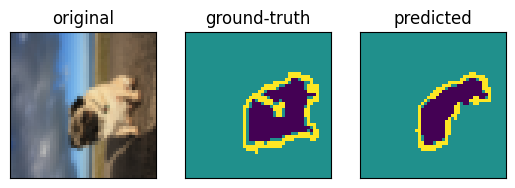

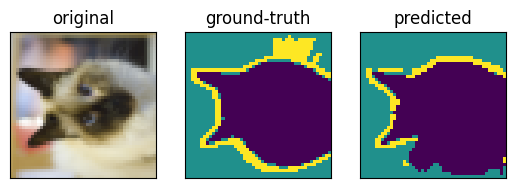

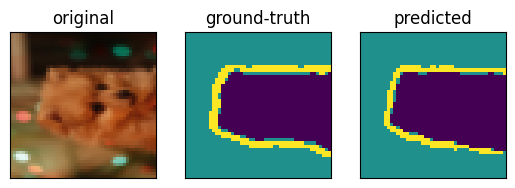

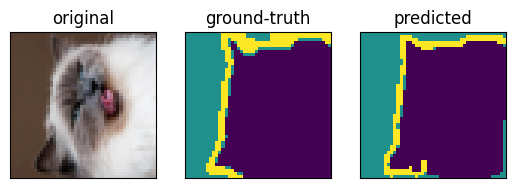

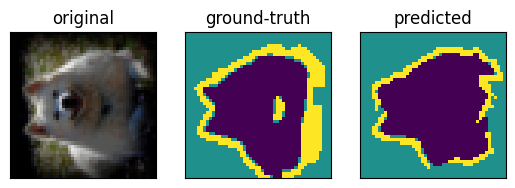

In [ ]:
show_predictions(test_loader, unet_model, 5)

**Define DICE Loss**

In [16]:
def dice_loss(pred, target):
    smooth = 1e-5
    dice = 0.
    pred = F.softmax(pred, dim=1).flatten(0,1)
    target = target.flatten(0,1)
    intersection = (pred * target).sum(dim=(-1,-2))
    union = pred.sum(dim=(-1,-2)) + target.sum(dim=(-1,-2))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

**Train the model with Max pooling + Transpose convolution + DICE Loss**

In [17]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []

num_epochs=24
unet_model = UNet(in_channels=3,out_channels=3).to(device)
criterion = dice_loss
optimizer = torch.optim.Adam(unet_model.parameters())
for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(unet_model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    #this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



epoch: 1


loss=0.34938728140668407 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.95it/s]


epoch: 2


loss=0.3114528566599364 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.61it/s]


epoch: 3


loss=0.313867769206006 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.96it/s]


epoch: 4


loss=0.24302903513316332 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.50it/s]


epoch: 5


loss=0.2658320494262014 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.00it/s]


epoch: 6


loss=0.26291258378039917 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.60it/s]


epoch: 7


loss=0.22571817723578602 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.69it/s]


epoch: 8


loss=0.26228956654078883 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.83it/s]


epoch: 9


loss=0.24533900679423437 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.01it/s]


epoch: 10


loss=0.23076848694251273 batch_id=114: 100%|██████████| 115/115 [00:20<00:00,  5.65it/s]


epoch: 11


loss=0.2572544529501277 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.04it/s]


epoch: 12


loss=0.26054481689804865 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.75it/s]


epoch: 13


loss=0.2164468498670531 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.02it/s]


epoch: 14


loss=0.23333053483181443 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.81it/s]


epoch: 15


loss=0.20891158584569935 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.92it/s]


epoch: 16


loss=0.23305771317620905 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.78it/s]


epoch: 17


loss=0.19244819777200828 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.97it/s]


epoch: 18


loss=0.1940559754507294 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.86it/s]


epoch: 19


loss=0.21151073449384827 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.99it/s]


epoch: 20


loss=0.2308497035206465 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.75it/s]


epoch: 21


loss=0.23948943610772488 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.90it/s]


epoch: 22


loss=0.18756317572239745 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.80it/s]


epoch: 23


loss=0.2011609353163326 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.94it/s]


epoch: 24


loss=0.20674504521671766 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.84it/s]


**Show predictions from DICE Loss**

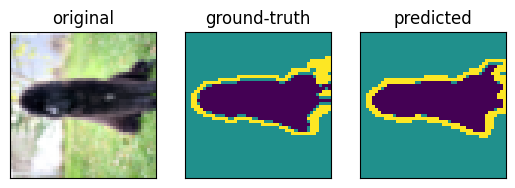

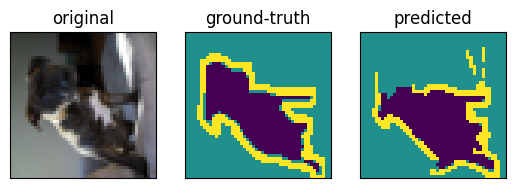

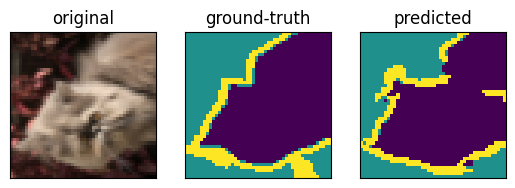

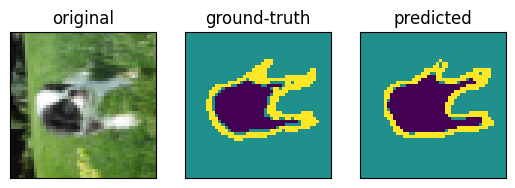

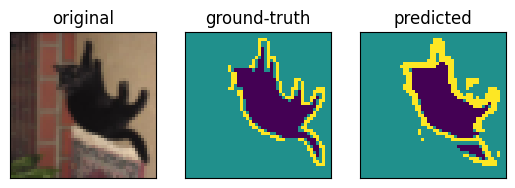

In [20]:
show_predictions(test_loader, unet_model, 5)